# THIS CODE CONCATENATES WITH INVERSE VAR WEIGHTING

In [3]:
from astropy.table import Table, vstack, Column, MaskedColumn, pprint
import numpy as np

import matplotlib 
import matplotlib.pyplot as plt
from astropy.convolution import convolve, Gaussian1DKernel

from astropy.io import fits
from matplotlib.backends.backend_pdf import PdfPages

import os
import requests
import sys
sys.path.append('/Users/s2537809/DESI/desispec/py')
sys.path.append('/Users/s2537809/DESI/desimodel/py')
sys.path.append('/Users/s2537809/DESI/desitarget/py')
sys.path.append('/Users/s2537809/DESI/desiutil/py')

#from desispec.io import read_spectra
# import DESI related modules - 
from desimodel.footprint import radec2pix      # For getting healpix values
import desispec.io                             # Input/Output functions related to DESI spectra
from desispec import coaddition                # Functions related to coadding the spectra


from scipy import interpolate
import astropy.units as u
path='/Users/s2537809/Documents/DESI-STACKING'#specify code directory
os.chdir(path)
import stack_code as sc
import importlib
import fnmatch
import extinction as ext
from scipy.optimize import curve_fit
from astropy.coordinates import SkyCoord
from astropy.modeling import models
from astropy.table import Table
from matplotlib import gridspec
import spectres
import time
import warnings

#pip install lmfit, extinction, sfdmap, spectres

import pandas as pd
crossmatch = Table.read('crossmatch_classifications.fits', format = 'fits' )

/Users/s2537809/DESI/desispec/py/desispec/qproc/qextract.py:19: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def numba_extract(image_flux,image_var,x,hw=3) :
/Users/s2537809/DESI/desispec/py/desispec/image_model.py:27: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def numba_proj(image,x,sigma,flux) :
/Users/s2537809/DESI/desispec/py/desispec/preproc.py:379: Num

## Cell below verifies if Spectra are downloaded and downloads if they aren't

Only run if unsure if spectra are downloaded, to save time!

In [2]:
"""
Note: The lengths for indexing are:

HERG = 184

RQAGN = 814

LERG = 1293

SFG = 6294

"""


Overall_class = 'SFG'
my_table = crossmatch[crossmatch['Overall_class'] == f'{Overall_class}'][1000:1200]
search_column_name = 'TARGETID'
search_values = np.array(my_table[f'{search_column_name}'])



def select_data(table, column_name, search_values):
    # Get the column data as a numpy array
    column_data = table[column_name]

    SURVEY = []
    PROGRAM = []
    HEALPIX = []
    n_values = []
    Z = []
    

    for search_value in search_values:
        # Find the indices where the condition is met (value == search_value)
        indices = np.where(column_data == search_value)[0]


        if len(indices) > 0:
            # Find the corresponding Survey, program, healpix, and Z values
            SURVEY.append(table['SURVEY'][indices[0]])
            PROGRAM.append(table['PROGRAM'][indices[0]])
            HEALPIX.append(table['HEALPIX'][indices[0]])
            Z.append(table['Z'][indices[0]])
            HEALPIX_str = str(table['HEALPIX'][indices[0]])
            n_str = HEALPIX_str[:3]
            n_values.append(int(n_str))
        else:
            # Handle the case where the search value was not found
            SURVEY.append(None)
            PROGRAM.append(None)
            HEALPIX.append(None)
            n_values.append(None)
            Z.append(None)
    

    return np.array(SURVEY), np.array(PROGRAM), np.array(HEALPIX), np.array(n_values), np.array(Z), 


SURVEY = select_data(my_table, search_column_name, search_values)[0]
PROGRAM = select_data(my_table, search_column_name, search_values)[1]
HEALPIX = select_data(my_table, search_column_name, search_values)[2]
n = select_data(my_table, search_column_name, search_values)[3]
Z = select_data(my_table, search_column_name, search_values)[4]
print (SURVEY,PROGRAM,HEALPIX, n, Z)

for n, survey, program, healpix, Z, search_value in zip(n, SURVEY, PROGRAM, HEALPIX, Z, search_values):
        #download the file from the given Target ID
        target_url = f"https://data.desi.lbl.gov/public/edr/spectro/redux/fuji/healpix/{survey}/{program}/{n}/{healpix}/coadd-{survey}-{program}-{healpix}.fits"
        
        # Define the folder name and file name
        folder_name = 'DESI_Downloads'
        file_name = f"coadd-{survey}-{program}-{healpix}.fits"
        print(search_value)


        # Check if the folder exists, and create it if it doesn't
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)

        # Check if the file exists in the folder
        file_path = os.path.join(folder_name, file_name)
        if os.path.exists(file_path):
            print(f"{file_name} already exists in {folder_name}. No need to download.")
        else:
            # File doesn't exist, download it
            try:
                response = requests.get(target_url)
                if response.status_code == 200:
                    with open(file_path, 'wb') as file:
                        file.write(response.content)
                    print(f"{file_name} downloaded to {folder_name}.")
                else:
                    print(f"Failed to download {file_name}. Status code: {response.status_code}")
            except Exception as e:
                print(f"An error occurred while downloading {file_name}: {str(e)}")

      

['sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3'
 'sv3' 'sv1' 'sv1' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv3' 'sv1' 'sv1'
 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv1' 'sv1'
 'sv1' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv1' 'sv3'
 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3'
 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3'
 'sv1' 'sv3' 'sv3' 'sv1' 'sv1' 'sv1' 'sv1' 'sv1' 'sv3' 'sv1' 'sv3' 'sv3'
 'sv1' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv1' 'sv1' 'sv3' 'sv3' 'sv1'
 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3'
 'sv1' 'sv3' 'sv1' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3'
 'sv1' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv1' 'sv1' 'sv3'
 'sv1' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3' 'sv1' 'sv3' 'sv1' 'sv1' 'sv1' 'sv3'
 'sv1' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3'
 'sv1' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv3' 's

# Wavelength Overlap Regions Weighted Average

In [15]:
def inv_var_weighted_average(flux1, ivar1, flux2, ivar2):
    """
    Finds the inverse varience weighted average of two flux spectra
    
    """
    weight1 = 1 / ivar1
    weight2 = 1 / ivar2
    total_weight = weight1 + weight2
    weighted_flux1 = flux1 * (weight1 / total_weight)
    weighted_flux2 = flux2 * (weight2 / total_weight)
    weighted_avg = weighted_flux1 + weighted_flux2
    return weighted_avg

def no_overlap_f(waveb,fluxb,waver,fluxr,wavez,fluxz):
    """
    Isolates the flux and wavelength arrays of each band to non-overlapping wavelength sections
    
    """
    new_b_length = np.where(waveb<waver[0])
    b_wave = waveb[new_b_length]
    b_flux = fluxb[new_b_length]
    new_r_length = np.where((waver>waveb[-1])&(waver<wavez[0]))
    r_wave = waver[new_r_length]
    r_flux = fluxr[new_r_length]
    new_z_length = np.where(wavez>waver[-1])
    z_wave = wavez[new_z_length]
    z_flux = fluxz[new_z_length]

    return b_wave,b_flux,r_wave,r_flux,z_wave,z_flux


def overlap_av(wave1,wave2,flux1,flux2,ivar1,ivar2):
    """
    Finds the overlap of two wavelength ranges.
    Computes the inverse var weighted average flux and wavelength for th eoverlapping range 
    
    """
    overlap_idx_1 = np.where(wave1 >= wave2[0]) 
    overlap_wave = wave1[overlap_idx_1]
    overlap_flux_1 = flux1[overlap_idx_1]
    overlap_ivar_1 = ivar1[overlap_idx_1]

    overlap_idx_2 = np.where(wave2 <= wave1[-1]) 
    overlap_flux_2 = flux2[overlap_idx_2]
    overlap_ivar_2 = ivar2[overlap_idx_2]
    
    overlap_av_flux = inv_var_weighted_average(overlap_flux_1,overlap_ivar_1,overlap_flux_2,overlap_ivar_2)

    return overlap_av_flux, overlap_wave

# Stacking Functions 

In [16]:
#stacking functions

# Ignore warnings due to spec_var=0
warnings.filterwarnings("ignore", message="divide by zero encountered in true_divide")


def get_spectra(table, column_name, search_values): 
    print('Number of spectra =', len(table))
    # Get the Target IDs as a numpy array
    column_data = table[column_name]

    SURVEY, PROGRAM, HEALPIX, n_values = [], [], [], []
    Z, RA, DEC, Source_ID = [], [], [], []


    for search_value in search_values:
        # Find the indices where the condition is met (value == search_value)
        # This is only relevant if input is doen by search value and not selected table
        indices = np.where(column_data == search_value)[0]

        if len(indices) > 0:
            # Find the corresponding Survey, program, healpix, Z , RA and Dec values
            SURVEY.append(table['SURVEY'][indices[0]])
            PROGRAM.append(table['PROGRAM'][indices[0]])
            HEALPIX.append(table['HEALPIX'][indices[0]])
            Z.append(table['Z'][indices[0]])
            RA.append(table['TARGET_RA'][indices[0]]) 
            DEC.append(table['TARGET_DEC'][indices[0]])
            Source_ID.append(table['TARGETID'][indices[0]])
            HEALPIX_str = str(table['HEALPIX'][indices[0]])
            n_str = HEALPIX_str[:3]
            n_values.append(int(n_str))
        else:
            # Handle the case where the search value was not found
            SURVEY.append(None)
            PROGRAM.append(None)
            HEALPIX.append(None)
            n_values.append(None)
            Z.append(None)   
            RA.append(None)
            DEC.append(None)
            Source_ID.append(None)
            
    
    z = np.array(Z)
    RA = np.array(RA)
    DEC = np.array(DEC)
    id_spec = np.array(Source_ID)
    wave_spec, flux_spec, sigma_spec = [], [], []
    
    for index, (survey, program, healpix, search_value) in enumerate(zip(SURVEY, PROGRAM, HEALPIX, search_values)):
        
        folder_name = 'DESI_Downloads'
        file_name = f"coadd-{survey}-{program}-{healpix}.fits"
        coadd_obj = desispec.io.read_spectra(f'{folder_name}/{file_name}')
        coadd_tgts = coadd_obj.target_ids().data
        # Selecting the particular spectra of the targetid
        row = (coadd_tgts == search_value)
        coadd_spec = coadd_obj[row] 

        # Inverse Vartiance weighted average for overlap
        no_overlap = no_overlap_f(coadd_spec.wave['b'],coadd_spec.flux['b'][0],coadd_spec.wave['r'],coadd_spec.flux['r'][0],coadd_spec.wave['z'],coadd_spec.flux['z'][0])
        overlap_br= overlap_av(coadd_spec.wave['b'],coadd_spec.wave['r'],coadd_spec.flux['b'][0],coadd_spec.flux['r'][0],coadd_spec.ivar['b'][0],coadd_spec.ivar['r'][0])
        overlap_rz= overlap_av(coadd_spec.wave['r'],coadd_spec.wave['z'],coadd_spec.flux['r'][0],coadd_spec.flux['z'][0],coadd_spec.ivar['r'][0],coadd_spec.ivar['z'][0])
        
        
        # Concaternating Spectra
        flux_spectra = np.concatenate((no_overlap[1],overlap_br[0],no_overlap[3],overlap_rz[0],no_overlap[5]))
        wave_spectra = np.concatenate((no_overlap[0],overlap_br[1],no_overlap[2],overlap_rz[1],no_overlap[4]))

        # Using Desispec to get wavelengths, flux and sigma
        wave = wave_spectra
        wave = wave.flatten()
        #flux = coadd_spec.flux['r'][0]
        #flux = convolve(flux_spectra, Gaussian1DKernel(5))
        #pick if i want to convolve or not
        flux = flux_spectra
        flux = flux.flatten()
        sigma = (np.sqrt(1/coadd_spec.ivar['r']))
        sigma = sigma.flatten()
        if index % 2 == 0 and len(wave) > 0:
                wave = wave[:-1]
                flux = flux[:-1]
                sigma = sigma[:-1]
        sigma_spec.append(sigma)
        wave_spec.append(wave)
        flux_spec.append(flux)
        
    
    wave_spec = np.array(wave_spec,dtype=object)
    flux_spec = np.array(flux_spec,dtype=object)
    sigma_spec = np.array(sigma_spec,dtype=object)
    # alternatively tried wave_spec = wave_spec.tolist()

    
    
    return wave_spec, flux_spec, sigma_spec, z, RA, DEC, id_spec


def get_stack(spec, zbins=None):# can add redshift ranges i.e zbins = [[0.0,0.1],[0.1,0.2]]
    wave_spec, flux_spec, sigma_spec, z, RA, DEC, id_spec= spec
    stack = sc.stack_spectra(wave_spec,flux_spec,sigma_spec,
                               z, RA, DEC, zbins = zbins)
    return stack

## Spectra Selection and Application of Stacking

In [38]:
# Bin the data by flux (proxy for SFR?) or mass 


var_bin = 'Total_flux'
crossmatch = crossmatch[np.array(np.argsort(crossmatch[f'{var_bin}']))]


Overall_class = 'HERG'
total_objects = 184
bins = 3
table_size = total_objects // bins

# Create a list to store the tables
tables = []

# Loop to create each table
for i in range(bins):
    start_index = i * table_size
    end_index = (i + 1) * table_size if i < bins - 1 else total_objects
    
    # Create a table for the current segment
    current_table = crossmatch[crossmatch['Overall_class'] == f'{Overall_class}'][start_index:end_index]
    
    # Append the table to the list
    tables.append(current_table)

# There are tables 0 to 5
#print(tables[1])

# Create a list to store the stack outputs
stack_outputs = []

# Perform operations for each table
for i, table in enumerate(tables):
    search_column_name = 'TARGETID'
    search_values = np.array(table[f'{search_column_name}'])
    
    # Extract relevant spectra
    spec = get_spectra(table, search_column_name, search_values)
    
    # Stack spectra
    stack = get_stack(spec)

    # Append the stack output to the list
    stack_outputs.append(stack)


    

Number of spectra = 61
INFO:spectra.py:372:read_spectra: iotime 2.355 sec to read coadd-sv3-dark-10153.fits at 2024-01-07T15:06:32.557018


/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_32472/3924121423.py:7: RuntimeWarning: divide by zero encountered in divide
  weight2 = 1 / ivar2
/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_32472/3924121423.py:10: RuntimeWarning: invalid value encountered in divide
  weighted_flux2 = flux2 * (weight2 / total_weight)
/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_32472/3924121423.py:6: RuntimeWarning: divide by zero encountered in divide
  weight1 = 1 / ivar1
/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_32472/3924121423.py:9: RuntimeWarning: invalid value encountered in divide
  weighted_flux1 = flux1 * (weight1 / total_weight)
/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_32472/87081193.py:80: RuntimeWarning: divide by zero encountered in divide
  sigma = (np.sqrt(1/coadd_spec.ivar['r']))


INFO:spectra.py:372:read_spectra: iotime 3.135 sec to read coadd-sv3-dark-10155.fits at 2024-01-07T15:06:36.467298
INFO:spectra.py:372:read_spectra: iotime 2.298 sec to read coadd-sv3-dark-10150.fits at 2024-01-07T15:06:40.152409
INFO:spectra.py:372:read_spectra: iotime 1.660 sec to read coadd-sv3-dark-10147.fits at 2024-01-07T15:06:42.963832
INFO:spectra.py:372:read_spectra: iotime 2.299 sec to read coadd-sv3-dark-10153.fits at 2024-01-07T15:06:45.737814
INFO:spectra.py:372:read_spectra: iotime 3.164 sec to read coadd-sv3-dark-11521.fits at 2024-01-07T15:06:49.619193
INFO:spectra.py:372:read_spectra: iotime 2.295 sec to read coadd-sv3-bright-10156.fits at 2024-01-07T15:06:53.540044
INFO:spectra.py:372:read_spectra: iotime 1.586 sec to read coadd-sv3-dark-10147.fits at 2024-01-07T15:06:56.043573
INFO:spectra.py:372:read_spectra: iotime 1.231 sec to read coadd-sv3-dark-10152.fits at 2024-01-07T15:06:57.685169
INFO:spectra.py:372:read_spectra: iotime 0.573 sec to read coadd-sv1-other-101

/Users/s2537809/anaconda3/envs/py3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/s2537809/anaconda3/envs/py3.9/lib/python3.9/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Stack[0]: [nan nan nan ... nan nan nan]
Stack[1]: [nan nan nan ... nan nan nan]
Stack[2]: [1. 1. 1. ... 3. 3. 2.]
Number of spectra = 61
INFO:spectra.py:372:read_spectra: iotime 1.119 sec to read coadd-sv3-dark-11524.fits at 2024-01-07T15:09:19.092102
INFO:spectra.py:372:read_spectra: iotime 1.073 sec to read coadd-sv3-dark-11524.fits at 2024-01-07T15:09:20.391555
INFO:spectra.py:372:read_spectra: iotime 1.971 sec to read coadd-sv3-bright-10155.fits at 2024-01-07T15:09:22.645068
INFO:spectra.py:372:read_spectra: iotime 2.436 sec to read coadd-sv3-bright-10156.fits at 2024-01-07T15:09:25.570719
INFO:spectra.py:372:read_spectra: iotime 2.115 sec to read coadd-sv3-dark-10154.fits at 2024-01-07T15:09:29.391194
INFO:spectra.py:372:read_spectra: iotime 2.340 sec to read coadd-sv3-dark-10155.fits at 2024-01-07T15:09:32.444120
INFO:spectra.py:372:read_spectra: iotime 2.342 sec to read coadd-sv3-dark-10153.fits at 2024-01-07T15:09:35.733349
INFO:spectra.py:372:read_spectra: iotime 0.462 sec to 

In [43]:
stack_outputs[2]

{'zbin=0': {'flux': array([nan, nan, nan, ..., nan, nan, nan]),
  'flux_err': array([nan, nan, nan, ..., nan, nan, nan]),
  'N': array([1., 1., 1., ..., 1., 1., 1.]),
  'wln': array([ 827.5,  828.5,  829.5, ..., 9841.5, 9842.5, 9843.5]),
  'norm_range': array([2210, 2211, 2212, 2213, 2214, 2215, 2216, 2217, 2218, 2219, 2220])}}

In [30]:

"""

b: 3600.0 5800.0000000005 r: 5760.0 7620.000000000423 z: 7520.0


Note: The lengths for indexing are:

HERG = 184

RQAGN = 814

LERG = 1293

SFG = 6294

"""

# Select varibale to sort by
#Mass_median or Total_flux from LOFAR?

Overall_class = 'SFG'
my_table = crossmatch[crossmatch['Overall_class'] == f'{Overall_class}'][0:100]
search_column_name = 'TARGETID'
search_values = np.array(my_table[f'{search_column_name}'])


SFG_spec=get_spectra(my_table,search_column_name,search_values) #extracts relevant spectra

SFG_stack = get_stack(SFG_spec) #stacks spectra


Number of spectra = 100
INFO:spectra.py:372:read_spectra: iotime 1.624 sec to read coadd-sv1-other-10156.fits at 2024-01-07T14:04:53.889729
INFO:spectra.py:372:read_spectra: iotime 1.009 sec to read coadd-sv1-other-10153.fits at 2024-01-07T14:05:00.230894
INFO:spectra.py:372:read_spectra: iotime 6.587 sec to read coadd-sv3-bright-10156.fits at 2024-01-07T14:05:08.136089
INFO:spectra.py:372:read_spectra: iotime 6.086 sec to read coadd-sv3-dark-11521.fits at 2024-01-07T14:05:19.253633
INFO:spectra.py:372:read_spectra: iotime 4.318 sec to read coadd-sv3-bright-10155.fits at 2024-01-07T14:05:28.643283


/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_32472/3924121423.py:6: RuntimeWarning: divide by zero encountered in divide
  weight1 = 1 / ivar1
/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_32472/3924121423.py:9: RuntimeWarning: invalid value encountered in divide
  weighted_flux1 = flux1 * (weight1 / total_weight)
/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_32472/87081193.py:80: RuntimeWarning: divide by zero encountered in divide
  sigma = (np.sqrt(1/coadd_spec.ivar['r']))


INFO:spectra.py:372:read_spectra: iotime 1.715 sec to read coadd-sv1-other-10153.fits at 2024-01-07T14:05:33.897122
INFO:spectra.py:372:read_spectra: iotime 4.450 sec to read coadd-sv3-bright-10153.fits at 2024-01-07T14:05:40.361766
INFO:spectra.py:372:read_spectra: iotime 0.285 sec to read coadd-sv1-other-11524.fits at 2024-01-07T14:05:47.092063
INFO:spectra.py:372:read_spectra: iotime 0.917 sec to read coadd-sv1-other-10155.fits at 2024-01-07T14:05:48.584982
INFO:spectra.py:372:read_spectra: iotime 1.837 sec to read coadd-sv1-other-10155.fits at 2024-01-07T14:05:50.828470
INFO:spectra.py:372:read_spectra: iotime 1.149 sec to read coadd-sv1-other-11521.fits at 2024-01-07T14:05:53.360223


/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_32472/3924121423.py:7: RuntimeWarning: divide by zero encountered in divide
  weight2 = 1 / ivar2
/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_32472/3924121423.py:10: RuntimeWarning: invalid value encountered in divide
  weighted_flux2 = flux2 * (weight2 / total_weight)


INFO:spectra.py:372:read_spectra: iotime 3.509 sec to read coadd-sv3-bright-10153.fits at 2024-01-07T14:05:58.519682
INFO:spectra.py:372:read_spectra: iotime 1.628 sec to read coadd-sv1-other-10154.fits at 2024-01-07T14:06:05.014738
INFO:spectra.py:372:read_spectra: iotime 4.736 sec to read coadd-sv3-bright-10155.fits at 2024-01-07T14:06:12.480386
INFO:spectra.py:372:read_spectra: iotime 5.099 sec to read coadd-sv3-dark-11521.fits at 2024-01-07T14:06:22.542257
INFO:spectra.py:372:read_spectra: iotime 4.815 sec to read coadd-sv3-dark-10155.fits at 2024-01-07T14:06:33.252279
INFO:spectra.py:372:read_spectra: iotime 1.524 sec to read coadd-sv1-other-10156.fits at 2024-01-07T14:06:40.943471
INFO:spectra.py:372:read_spectra: iotime 3.894 sec to read coadd-sv3-bright-10155.fits at 2024-01-07T14:06:47.270902
INFO:spectra.py:372:read_spectra: iotime 1.421 sec to read coadd-sv1-other-10156.fits at 2024-01-07T14:06:52.897075
INFO:spectra.py:372:read_spectra: iotime 4.656 sec to read coadd-sv3-da

/Users/s2537809/Documents/DESI-STACKING/stack_code.py:248: RuntimeWarning: invalid value encountered in divide
  Fnorm = flux_new / np.median(flux_new[:, norm_range], axis=1, keepdims=True)


Stack[0]: [3.39054635 4.76134839 9.14861984 ...        nan        nan        nan]
Stack[1]: [3.39054635 4.76134839 9.14861984 ...        nan        nan        nan]
Stack[2]: [ 1.  1.  1. ... 13. 13.  7.]


In [ ]:
#stack spectra in two redshift bins (i.e 0<z<0.1 and 0.1<z<0.2) - need to alter
#SFG_stacks = get_stack(SFG_spec, zbins=[[0.0,0.5],[0.5,1.0],[1.0,4.0]])
#soemtimes the redshift is less than 0?

## try adjusting these boundarys and adding more bins instead of binning seperately

## Plot Stacked Spectra

In [18]:
print('Min:',SFG_stack['zbin=0']['wln'][0])
print('Max:',SFG_stack['zbin=0']['wln'][-1])

Min: 1117.5
Max: 9843.5


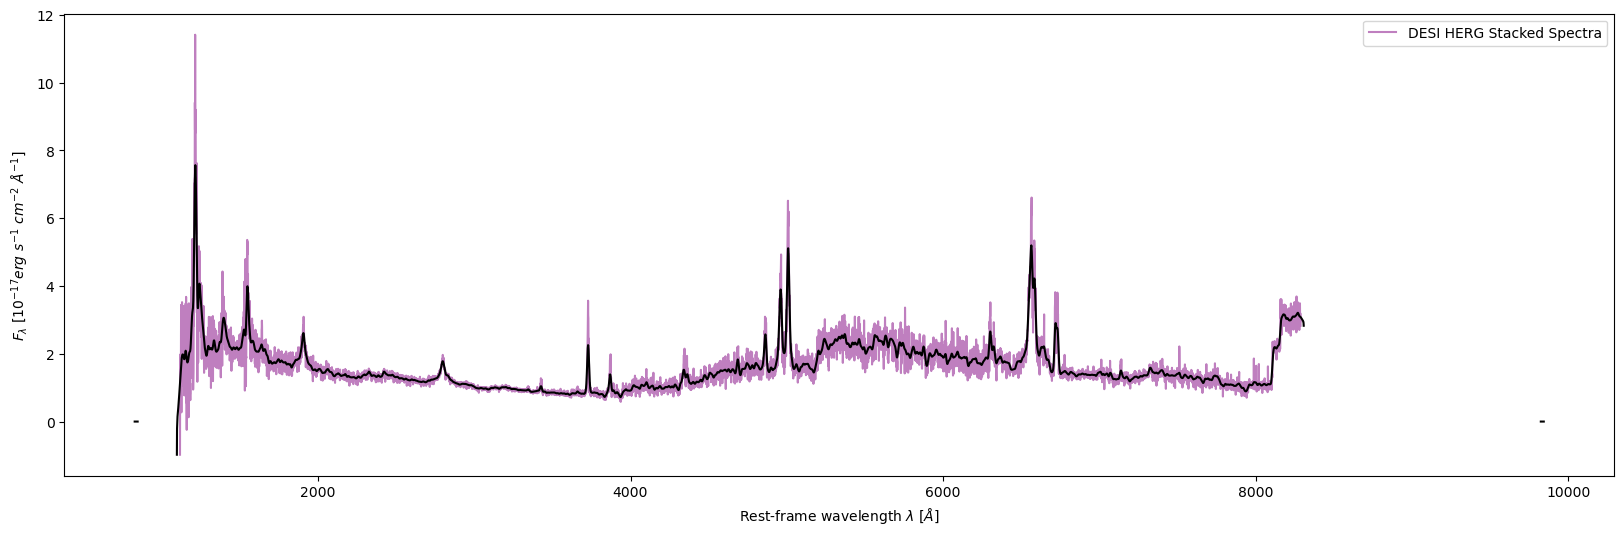

In [44]:
plt.figure(figsize=(20,6))
plt.plot(stack_outputs[2]['zbin=0']['wln'],stack_outputs[2]['zbin=0']['flux'], color='purple', alpha=0.5, label = f'DESI {Overall_class} Stacked Spectra')
plt.plot(stack_outputs[2]['zbin=0']['wln'],convolve(stack_outputs[2]['zbin=0']['flux'], Gaussian1DKernel(5)), color='black', alpha=1)
plt.ylabel('$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
plt.xlabel('Rest-frame wavelength $\lambda$ [$\AA$]')
plt.legend()

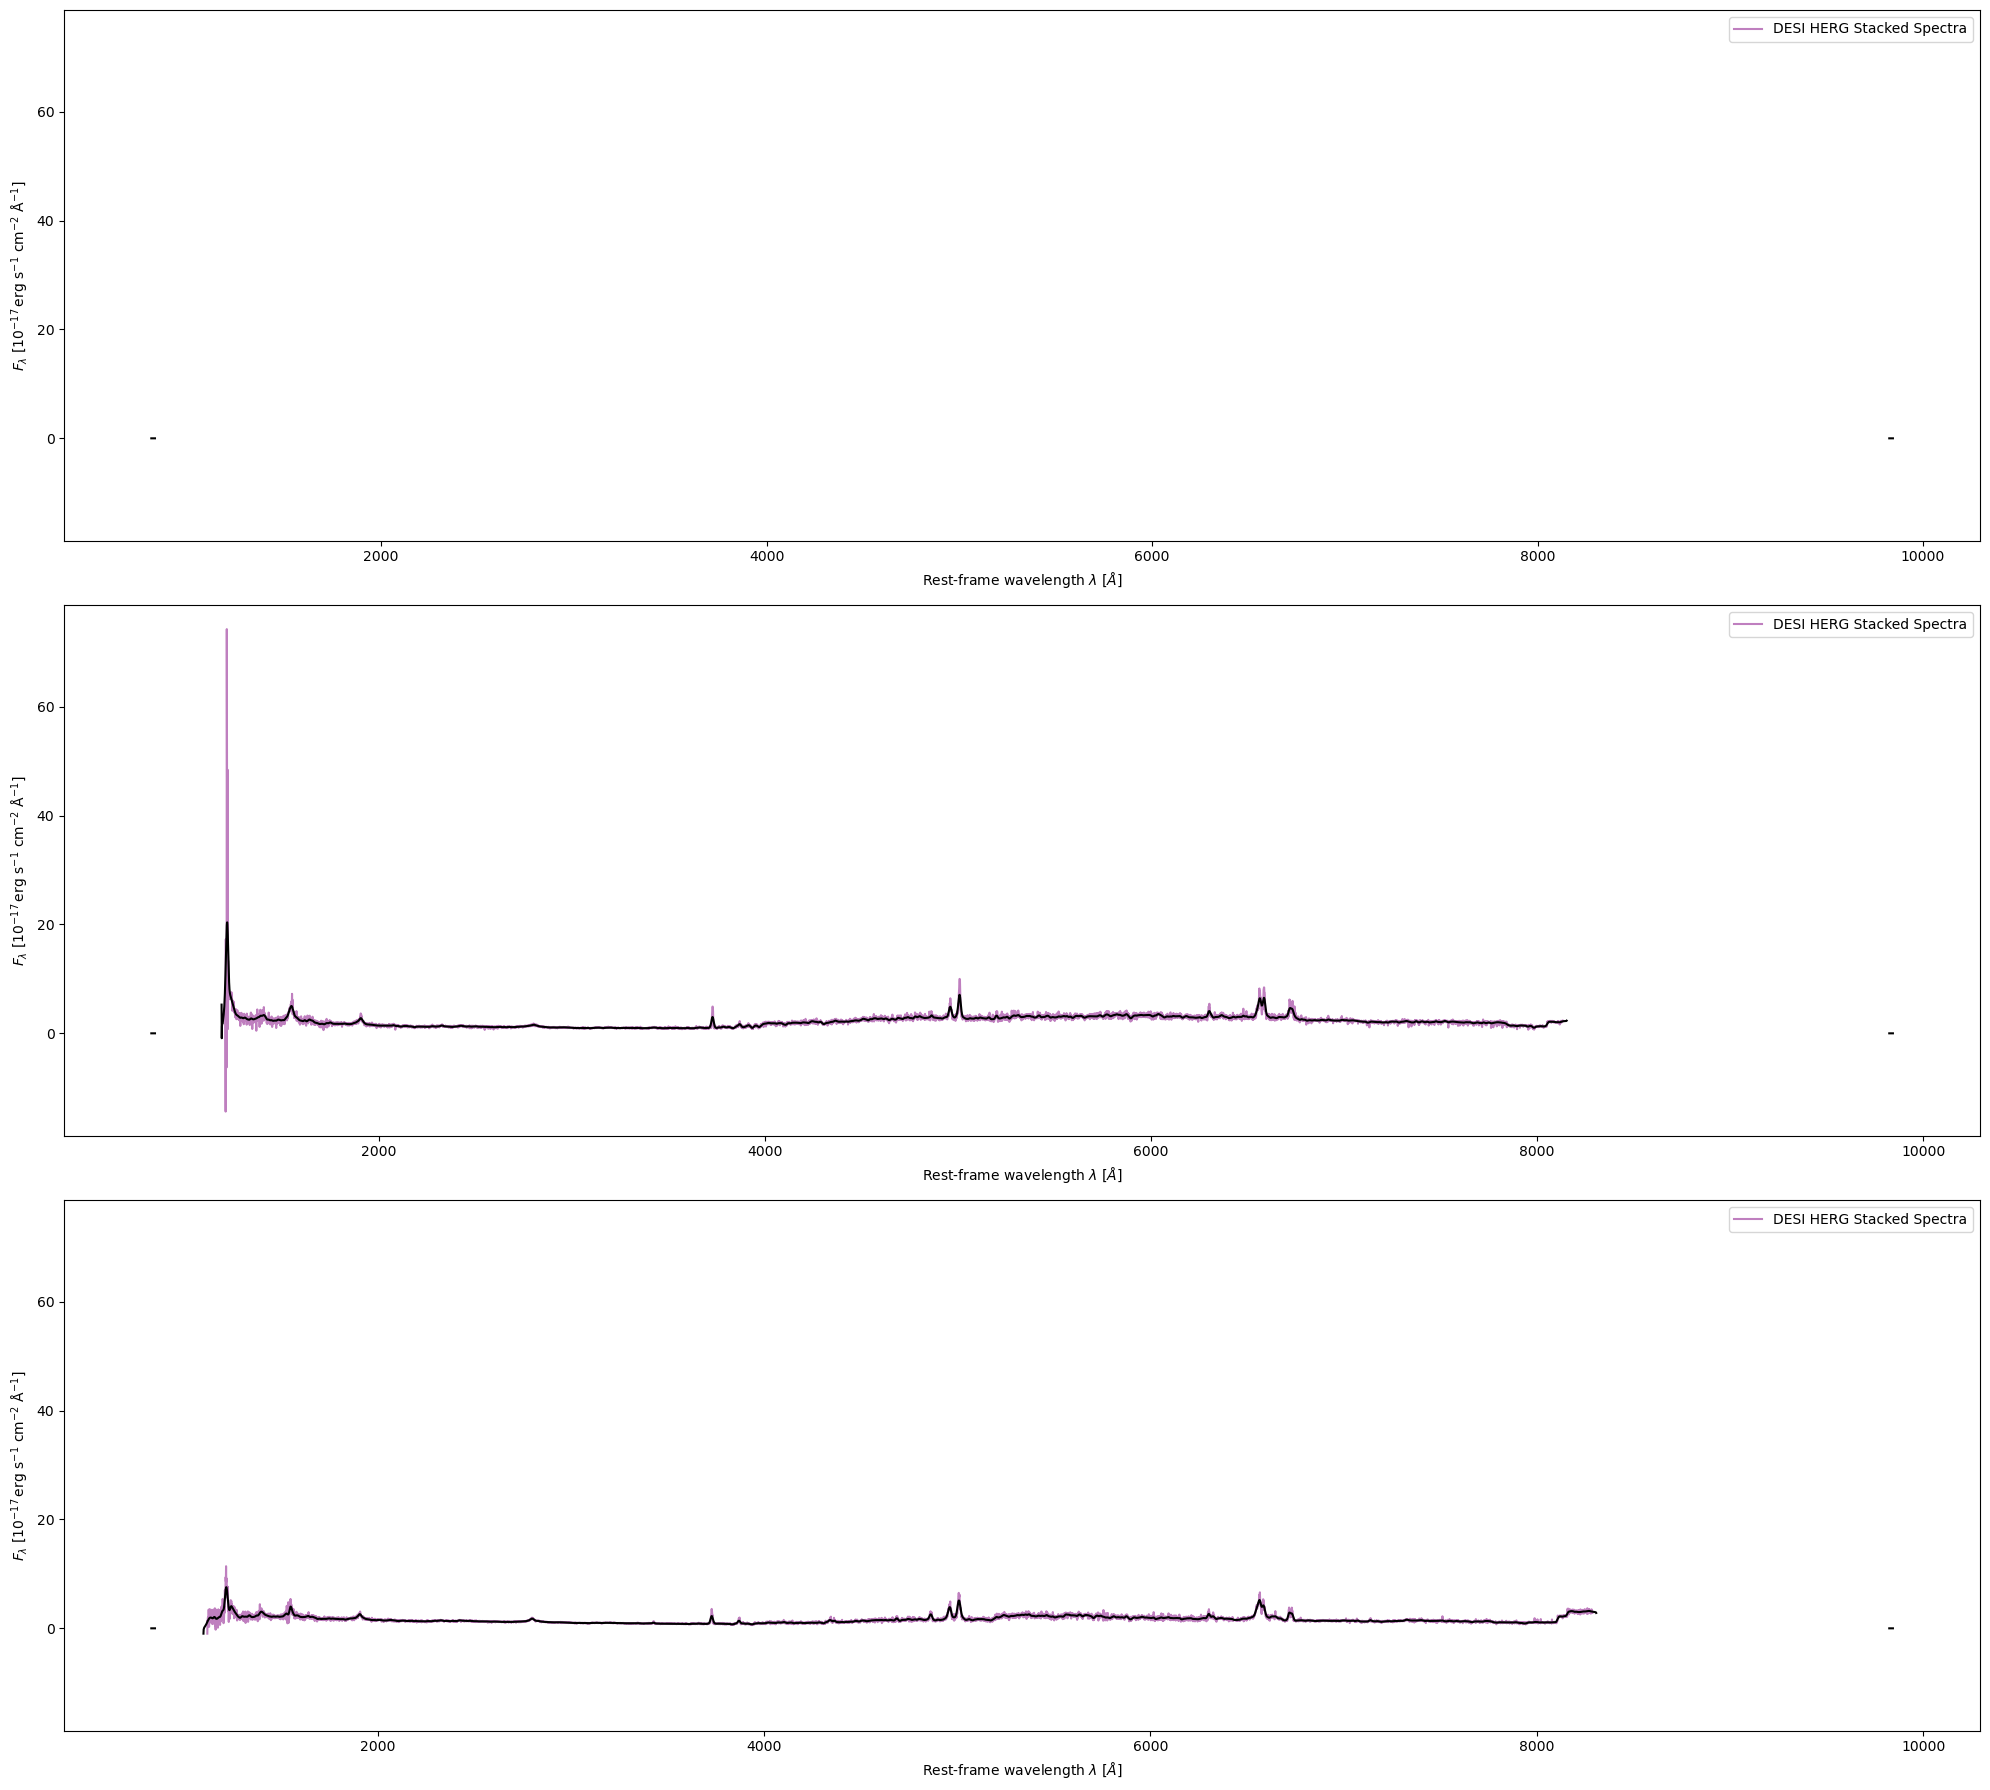

In [47]:

# Create a figure with three subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 18), sharey=True)

# Loop over each stack output and plot in a separate subplot
for i, stack_output in enumerate(stack_outputs):
    ax = axes[i]  # Select the current subplot
    
    # Plot the stacked spectra
    ax.plot(stack_output['zbin=0']['wln'], stack_output['zbin=0']['flux'], color='purple', alpha=0.5,
            label=f'DESI {Overall_class} Stacked Spectra')
    
    # Plot the convolved spectra
    ax.plot(stack_output['zbin=0']['wln'], convolve(stack_output['zbin=0']['flux'], Gaussian1DKernel(5)),
            color='black', alpha=1)
    
    ax.set_ylabel('$F_{\lambda}$ [$10^{-17} \, \mathrm{erg\ s^{-1}\ cm^{-2}\ \AA^{-1}}$]')
    ax.set_xlabel('Rest-frame wavelength $\lambda$ [$\AA$]')
    ax.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


All plots saved in DESI-SFG-stacked-plots-practice.pdf


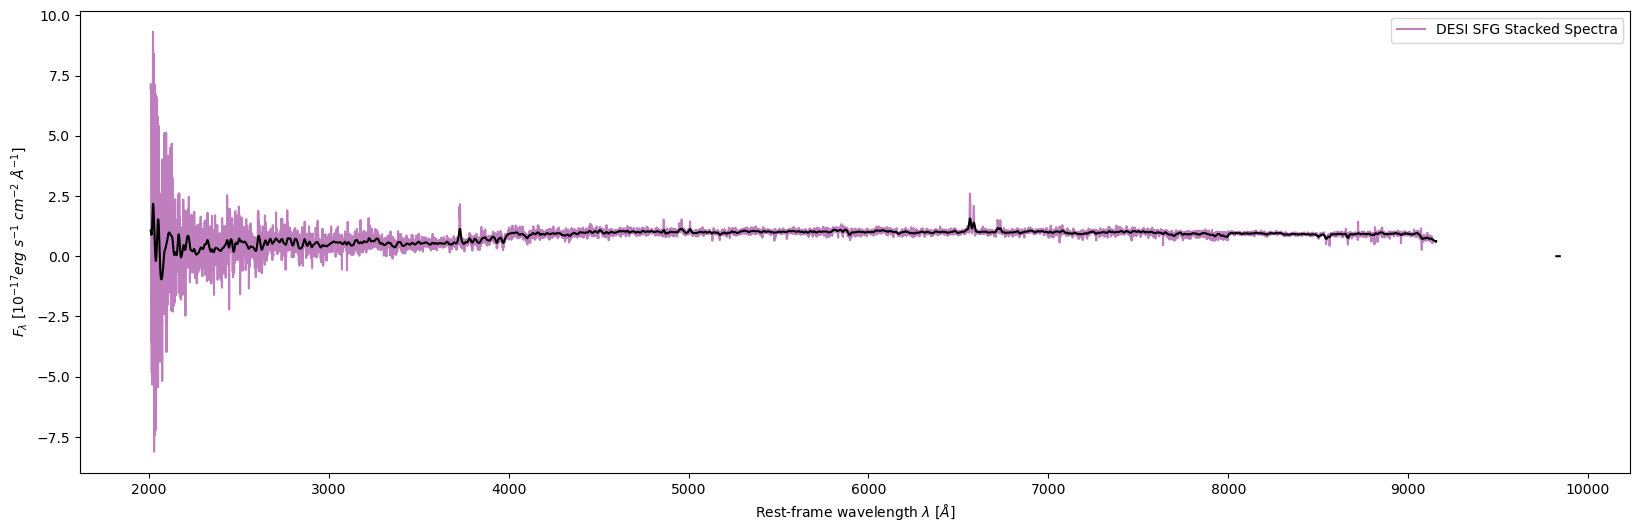

In [26]:
plt.figure(figsize=(20,6))
plt.plot(SFG_stack['zbin=0']['wln'],SFG_stack['zbin=0']['flux'], color='purple', alpha=0.5, label = f'DESI {Overall_class} Stacked Spectra')
plt.plot(SFG_stack['zbin=0']['wln'],convolve(SFG_stack['zbin=0']['flux'], Gaussian1DKernel(5)), color='black', alpha=1)
plt.ylabel('$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
plt.xlabel('Rest-frame wavelength $\lambda$ [$\AA$]')
plt.legend()

# Create a PDF file to save the plots
pdf_filename = f'DESI-{Overall_class}-stacked-plots-practice.pdf'
with PdfPages(pdf_filename) as pdf:
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.plot(SFG_stack['zbin=0']['wln'],SFG_stack['zbin=0']['flux'], color='purple', alpha=0.5,label = f'DESI {Overall_class} Stacked Spectra')
        ax.plot(SFG_stack['zbin=0']['wln'],convolve(SFG_stack['zbin=0']['flux'], Gaussian1DKernel(5)), color='black', alpha=1)
        ax.set_ylabel('$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
        ax.set_xlabel('Rest-frame wavelength, $\lambda$ [$\AA$]')
        ax.legend()

     # Save the current plot to the PDF file
        pdf.savefig(fig)
        plt.close()

# All the plots will be saved in the PDF file
print(f'All plots saved in {pdf_filename}')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


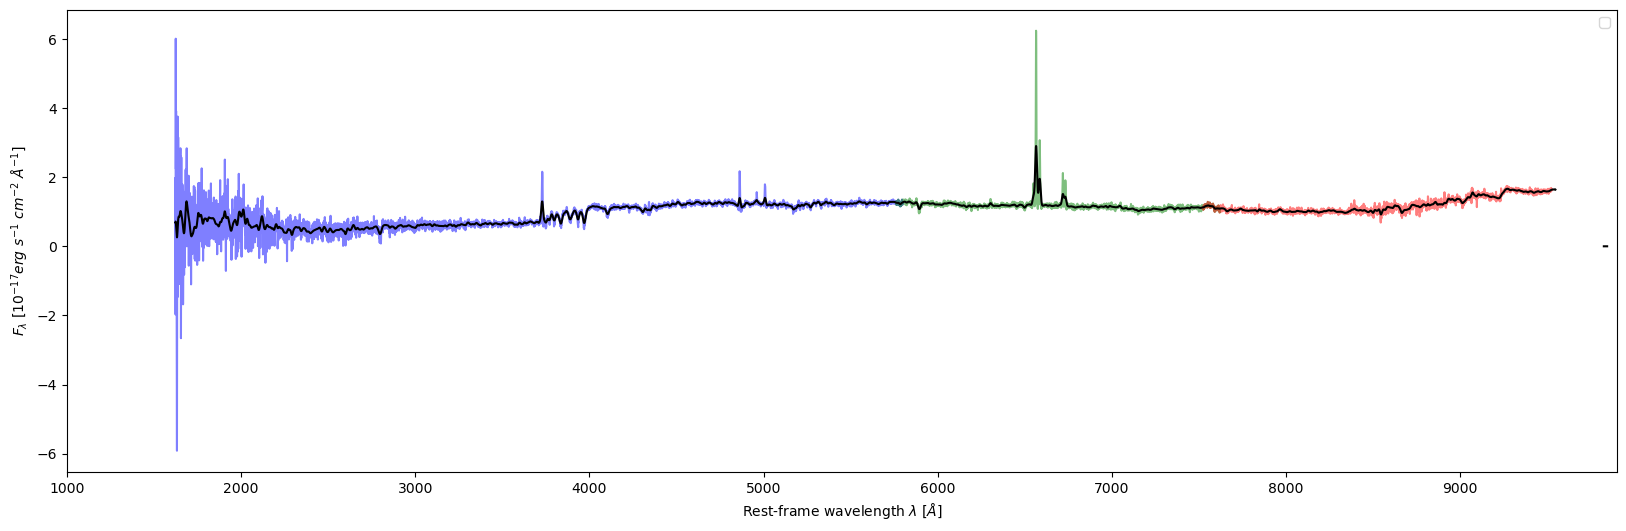

All plots saved in DESI-SFG-stacked-plots-practice.pdf


In [31]:
# Would need to adjust the wavelength ranges to the rest-fram wavelength ranges to do this



wavelength = SFG_stack['zbin=0']['wln']
flux = SFG_stack['zbin=0']['flux']

plt.figure(figsize=(20, 6))
plt.plot(wavelength[wavelength <= 5800], flux[wavelength <= 5800], color='blue', alpha=0.5)
plt.plot(wavelength[(wavelength > 5760) & (wavelength <= 7620)], flux[(wavelength > 5760) & (wavelength <= 7620)], color='green', alpha=0.5)
plt.plot(wavelength[wavelength > 7520], flux[wavelength > 7520], color='red', alpha=0.5)
plt.plot(SFG_stack['zbin=0']['wln'],convolve(SFG_stack['zbin=0']['flux'], Gaussian1DKernel(5)), color='black', alpha=1)
plt.ylabel('$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
plt.xlabel('Rest-frame wavelength $\lambda$ [$\AA$]')
plt.xlim(1000,9900)
plt.show()

# Create a PDF file to save the plots
pdf_filename = f'DESI-{Overall_class}-stacked-plots-practice.pdf'
with PdfPages(pdf_filename) as pdf:
        fig, ax = plt.subplots(figsize=(20, 6))
        ax.plot(wavelength[wavelength <= 5800], flux[wavelength <= 5800], color='blue', alpha=0.5)
        ax.plot(wavelength[(wavelength > 5760) & (wavelength <= 7620)], flux[(wavelength > 5760) & (wavelength <= 7620)], color='green', alpha=0.5)
        ax.plot(wavelength[wavelength > 7520], flux[wavelength > 7520], color='red', alpha=0.5)
        ax.plot(SFG_stack['zbin=0']['wln'],convolve(SFG_stack['zbin=0']['flux'], Gaussian1DKernel(5)), color='black', alpha=1)
        ax.set_ylabel('$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
        ax.set_xlabel('Rest-frame wavelength, $\lambda$ [$\AA$]')
        ax.set_xlim(3500,9900)

     # Save the current plot to the PDF file
        pdf.savefig(fig)
        plt.close()

# All the plots will be saved in the PDF file
print(f'All plots saved in {pdf_filename}')


### it appears that the problem is with the second half of the rqagn then ?? 
## it is the specifc values and not the size of the range ???


All plots saved in DESI-SFG-stacked-zbin-plots-practice.pdf


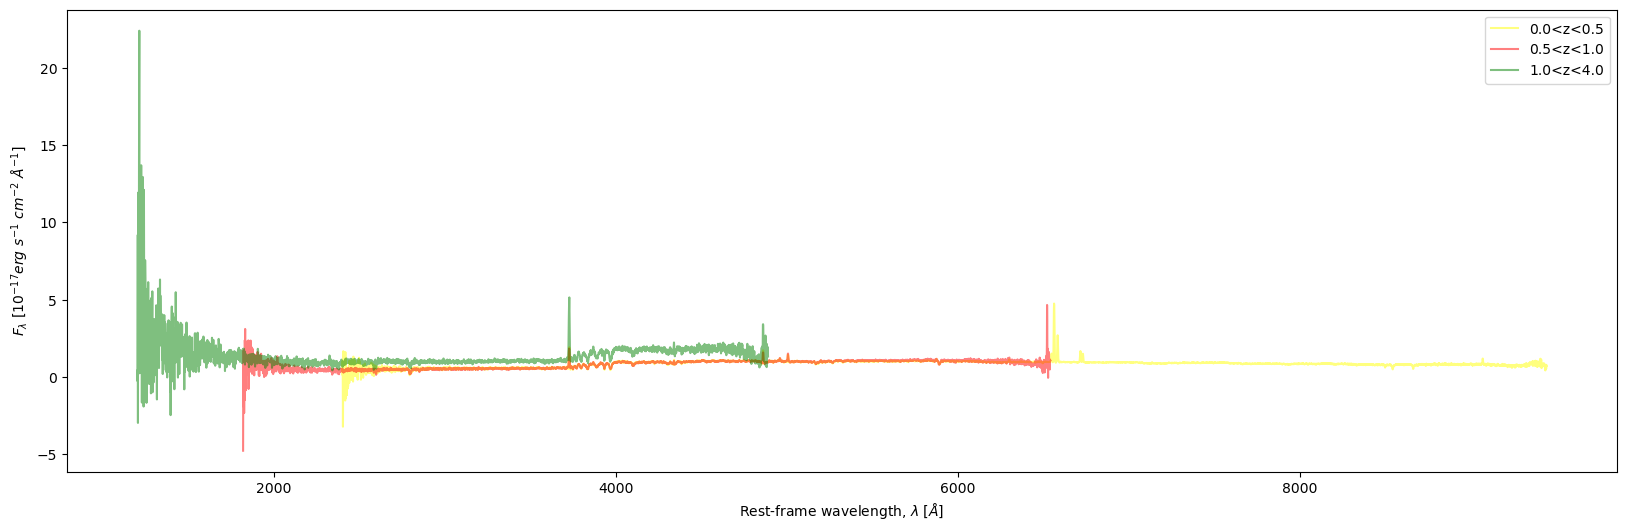

In [43]:
"""

The lack of simulated correction might be having an impact ?
Need to use different redshift bins - why does DESI have negative redshifts?
Why is there such a difference between the bins?

"""


plt.figure(figsize=(20,6))
plt.plot(SFG_stacks['zbin=0']['wln'],SFG_stacks['zbin=0']['flux'], label='0.0<z<0.5', color='yellow', alpha=0.5)
plt.plot(SFG_stacks['zbin=1']['wln'],SFG_stacks['zbin=1']['flux'], label='0.5<z<1.0', color='red', alpha=0.5)
plt.plot(SFG_stacks['zbin=2']['wln'],SFG_stacks['zbin=2']['flux'], label='1.0<z<4.0', color='green', alpha=0.5)
plt.ylabel('$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
plt.xlabel('Rest-frame wavelength, $\lambda$ [$\AA$]')
plt.legend()


# Create a PDF file to save the plots
pdf_filename = f'DESI-{Overall_class}-stacked-zbin-plots-practice.pdf'
with PdfPages(pdf_filename) as pdf:
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.plot(SFG_stacks['zbin=0']['wln'],SFG_stacks['zbin=0']['flux'], label='0.0<z<0.5', color='yellow', alpha=0.5)
        ax.plot(SFG_stacks['zbin=1']['wln'],SFG_stacks['zbin=1']['flux'], label='0.5<z<1.0', color='red', alpha=0.5)
        ax.plot(SFG_stacks['zbin=2']['wln'],SFG_stacks['zbin=2']['flux'], label='1.0<z<4.0', color='green', alpha=0.5)
        ax.set_ylabel('$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
        ax.set_xlabel('Rest-frame wavelength, $\lambda$ [$\AA$]')
        ax.legend()
     # Save the current plot to the PDF file
        pdf.savefig(fig)
        plt.close()

# After the loop, all the plots will be saved in the PDF file
print(f'All plots saved in {pdf_filename}')